## Consideraciones iniciales NLP y *Deep Learning*. Punto de partida

Hasta ahora habiamos trabajado con el concepto de "Bag of Words" en nuestros modelos para tratar de predecir el sentimiento de un texto. Este concepto o metodo trata cada texto como su nombre indica como una bolsa de palabras, ignorando su orden. 

Con el paso de los años el procesamiento de lenguaje natural (NLP) ha ido avanzando y alejandose de esta idea para quedarse con el *word embedding*. Esta se basa en la representación de una palabra a través de un vector de valor real que codifica el significado de la palabra de tal forma que las palabras que estan más "cercanas" en el espacio vectorial son similares entre sí.

Uno de los puntos de partida de este método fue gracias a [Mikolov et al. (2013)](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-com.pdf) y sus modelos de *Continouos Bag-of-Words* y *Skip-gram*. Lo que también se conoce como *word2vec*. 

De la misma forma una metodologia interesante del *Deep Learning* es la de *Transfer Learning*. Esta se basa en aprovechar un modelo pre-entrenado y combinarlo con un clasificador, de tal forma que puedan realizar tareas específicas. Esto al final resulta que de un modelo que ha sido entrenado con un conocimiento general sobre el lenguaje pueda ser adaptado sin la necesidad de tantos datos ni capacidad.



## Técnicas avanzadas NLP y *Deep Learning*. Sumario.

Aún así uno de los problemas que surgieron con los modelos de *embeddings* originales era que sus representaciones de palabras eran estáticas respecto a su contexto. Esto dificulta el tratamiento de palabras polisémicas.

Aquí es donde surgen los *transformers*. Son un tipo de modelo de lenguaje neuronal, basados en mecanismos de atención [(Vaswani et al., 2017)](http://papers.nips.cc/paper/7181-attention-is-all-you-%0Aneed.pdf), que permite generar representaciones continuas del texto completamente dependientes de su contexto.

Un [mecanismo de atención](https://wiki.pathmind.com/attention-mechanism-memory-network) asigna mayor o menor peso a diferentes partes de una secuencia, de acuerdo a un objetivo de aprendizaje. Los transformers combinan docenas de estos mecanismos para poder ponderar con suma precisión la relevancia de diferentes partes del texto con respecto a cada una de sus palabras. 

Uno de estos modelos es el BERT (*Bidirectional Encoder Representations from Transformers). Dicho modelo ha sido entrenado con 800 millones de palabras y la Wikipedia en inglés (2500 millones).

Utiliza *embeddings* de tamaño 768, aplia 12 *transformers* donde cada uno cuenta con 12 capas *multi-head attention*. Lo que resulta en un modelo con 110 millones de parámetros.

## RoBERTa (*A Robustly Optimized BERT Pretraining Approach*)

Para nuestro trabajo utilizaremos a modo de ejemplo y caso de estudio el modelo RoBERTa (*A Robustly Optimized BERT Pretraining Approach*). Dicho modelo esta construido sobre BERT únicamente ajustando algunos hiperparámetros clave.

A su vez disponemos de [modelos](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) pre-entrenados y que han aprovechado el *transfer learning* para dotar de RoBERTa de algunas funciones como el analisis de sentimiento especificamente en tweets. Otras funciones incluyen:

* [Emoticonos](https://huggingface.co/cardiffnlp/twitter-roberta-base-emoji)
* [Emociones](https://huggingface.co/cardiffnlp/twitter-roberta-base-emotion)
* [Discurso de odio](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate)
* [Ironia](https://huggingface.co/cardiffnlp/twitter-roberta-base-irony)
* [Discurso ofensivo](https://huggingface.co/cardiffnlp/twitter-roberta-base-offensive)

Cuenta con un dataset de entreno de 58 millones de tweets, si bien es cierto que sus últimas versiones cuentan con mas de 120 millones de tweets.



## Ejemplo de uso.

Aquí hemos descargado un dataset de tweets sobre nuestro caso de estudio y utilizaremos el modelo mencionado anteriormente para asignar las etiquetas. Más tarde volveremos a estimar los modelos de clasificación que habiamos visto, esto es: la regresión logística y el Multinomial Naives Bayes. Sumado también a una red LSTM sencilla.

In [ ]:
import pandas as pd
import torch
import numpy as np
train_on_gpu = torch.cuda.is_available()

if(train_on_gpu):
    device = torch.device('cuda')
    print('Training on GPU.')
else:
    device = torch.device('cpu')
    print('No GPU available, training on CPU.')

Training on GPU.


In [ ]:
sentiment_df=pd.read_csv('ejemplo_tweets.csv',lineterminator="\n")

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Cargamos modelo pre-entrenado

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment").to(device)

In [ ]:
import urllib
import csv

#definimos la tarea a realizar y las etiquetas/labels

labels=[]
task = 'sentiment'
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [ ]:
## NO EJECUTE EL CODIGO SI NO HAY GPUS DISPONIBLES

from scipy.special import softmax
BATCH_SIZE = 10

scores_all = np.empty((0,len(labels)))
text_all = sentiment_df['text'].to_list()
n = len(text_all)
with torch.no_grad():
    for start_idx in range(0, n, BATCH_SIZE):
        end_idx = min(start_idx+BATCH_SIZE, n)
        encoded_input = tokenizer(text_all[start_idx:end_idx], return_tensors='pt', padding=True, truncation=True).to(device)
        output = model(**encoded_input)
        scores = output[0].detach().cpu().numpy()
        scores = softmax(scores, axis=1)
        scores_all = np.concatenate((scores_all, scores), axis=0)
        del encoded_input, output, scores
        torch.cuda.empty_cache()
    

sentiment_df[labels] = pd.DataFrame(scores_all, columns=labels)

In [ ]:
#insertamos columna para el sentimiento
sentiment_df.insert("posicion de la columna aqui", "Sentiment", '')

In [ ]:
#en función de la puntuación/probabilidad asignamos etiqueta

for i in range(len(sentiment_df)):
  if sentiment_df['negative'][i] > sentiment_df['positive'][i] and sentiment_df['negative'][i] > sentiment_df['neutral'][i]:
    sentiment_df['Sentiment'][i] = 'negative'
  elif sentiment_df['positive'][i] > sentiment_df['negative'][i] and sentiment_df['positive'][i] > sentiment_df['neutral'][i]:
    sentiment_df['Sentiment'][i]= 'positive'
  else:
    sentiment_df['Sentiment'][i] = 'neutral'

In [ ]:
sentiment_df.drop(['negative','positive','neutral'], axis=1, inplace=True)

In [ ]:
sentiment_df.to_csv("./Tweets_Sentiment_Analysis_RoBERTa1.csv", index=False)

## 0. Preparación del entorno:

A partir de aqui y dado que debemos aplicar un modelo visto en el modulo 7 trabajaremos con las *Recurrent Neural Networks* (RNN). 

Estas redes permiten trabajar con el *word embedding* (representaciones distribuidas/continuas de palabras) y procesar la secuencia y su orden de forma precisa. Se denominan así porque la propagación se realiza sobre una única capa de forma recurrente, en lugar de aplicarse sobre capas sucesivas como ocurre en el perceptrón multi-capa.

En concreto trabajaremos con una forma algo más avanzada de las RNN básicas que son las *Long Short Term Memory* (LSTM). Estas se diferencian en que tienen una arquitectura modificada para mejorar la capacidad de la red neuronal de "recordar" dependencias alejadas. Esto significa que permite trabajar con secuencias más largas y dependencias más alejadas, como las que hay en muchos textos. 

Más adelante pondremos emfasis en alguna variación de estas redes que otorgan mejores resultados. Es el caso de la variante bidireccional, que procesan la información de izquierda a derecha y viceversa.

In [ ]:
import numpy as np 
import pandas as pd

from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth', None)

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
df=pd.read_csv('Tweets_Sentiment_Analysis_RoBERTa1.csv',lineterminator="\n")

In [ ]:
df.head()

,tweetid,text,hashtags,Sentiment
0,1503521359237951491,#Ukrainian President Volodymyr Zelensky will deliver a virtual speech to the US #Congress on Wednesday at 9 am.\n\n#Ukraine \nhttps://t.co/TPYT0PLf5D,"['Ukrainian', 'Congress', 'Ukraine']",neutral
1,1503521360286420995,"""Orthodox priests and deacons within #Ukraine and elsewhere have condemned Kirill’s coziness with #Putin’s aims and decry his attitude toward the invasion,"" writes @user http","['Ukraine', 'Putin']",negative
2,1503521360710193154,"#Australia is imposing new sanctions on 33 Russian oligarchs and business people, including Chelsea Football Club owner #Abramovich and #Gazprom CEO Alexey Miller, over the Russian invasion of Ukraine.\n\n#UkraineRussiaWar\n\nhttps://t.co/soSFMmUK3v","['Australia', 'Abramovich', 'Gazprom', 'UkraineRussiaWar']",negative
3,1503521361192497154,"As the ongoing conflict in #Ukraine drags on, #African countries would need to make some tough choices &amp; deftly maintain &amp; manage their relationships with their diverse set of external partners to protect their national interests, suggests @user \n\nhttps://t.co/d9fnNDmM0H","['Ukraine', 'African']",neutral
4,1503521361473552386,"Price #Inflation Hit a New 40-Year High in February. No, It's Not ""#Putin's Fault.""\nhttps://t.co/4fx9w9pHvF","['Inflation', 'Putin']",neutral


Comprobamos las dimensiones del dataset: tenemos 200 mil tweets aproximadamente.

In [ ]:
df["Sentiment"].value_counts()

negative    95813
neutral     74138
positive    30625
Name: Sentiment, dtype: int64

In [ ]:
df.shape

(200576, 4)

Otra vez y al igual que en el dataset que utilizamos anteriormente (mucho más reducido) tenemos un imbalanceo de clases.

In [ ]:
fig = px.histogram(df, x="Sentiment")
fig.update_traces(marker_color="indianred",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Tweet Sentiment')
fig.show()

Aplicamos limpieza de textos

In [ ]:
df['text'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df['text'] = df['text'].str.replace(r'\s*@\w+', '', regex=True)
df['text'] = df['text'].str.replace(r'\s*\B@\w+', '', regex=True)
df['text'] = df['text'].str.replace(r'\s*@\S+', '', regex=True)
df['text'] = df['text'].str.replace(r'\s*@\S+\b', '', regex=True)
df.text.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['text'] = df['text'].apply(lambda x : str(x).replace('\\n', ',').replace('\\', '').replace("'", "").replace("\n"," "))

In [ ]:
df['text'] = df['text'].apply(lambda x : str(x).replace('#', ''))

In [ ]:
df.head()

,tweetid,text,hashtags,Sentiment
0,1503521359237951491,Ukrainian President Volodymyr Zelensky will deliver a virtual speech to the US Congress on Wednesday at 9 am. Ukraine,"['Ukrainian', 'Congress', 'Ukraine']",neutral
1,1503521360286420995,"""Orthodox priests and deacons within Ukraine and elsewhere have condemned Kirills coziness with Putins aims and decry his attitude toward the invasion,"" writes http","['Ukraine', 'Putin']",negative
2,1503521360710193154,"Australia is imposing new sanctions on 33 Russian oligarchs and business people, including Chelsea Football Club owner Abramovich and Gazprom CEO Alexey Miller, over the Russian invasion of Ukraine. UkraineRussiaWar","['Australia', 'Abramovich', 'Gazprom', 'UkraineRussiaWar']",negative
3,1503521361192497154,"As the ongoing conflict in Ukraine drags on, African countries would need to make some tough choices &amp; deftly maintain &amp; manage their relationships with their diverse set of external partners to protect their national interests, suggests","['Ukraine', 'African']",neutral
4,1503521361473552386,"Price Inflation Hit a New 40-Year High in February. No, Its Not ""Putins Fault.""","['Inflation', 'Putin']",neutral


In [ ]:
df['text'] = df['text'].apply(lambda x : str(x).replace('#', '').replace('\\n', ',').replace('\\', '').replace("'", "").replace("\n"," "))

def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
df['text'] = df['text'].apply(remove_punctuation)

Convertimos los tweets y sus respectivas etiquetas a listas. También pasamos las etiquetas a números.

In [ ]:
revisiones_texto, etiquetas_texto =df["text"].tolist(), df["Sentiment"].tolist()
label_encoder = LabelEncoder()
label_encoder.fit(etiquetas_texto)
y = label_encoder.transform(etiquetas_texto)

Importamos librerias necesarias y añadimos una función para empezar una secuencia con un símbolo.

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
import random
import matplotlib.pyplot as plt
import numpy as np



def addBeginSeqSymbol(sequences): 
    newSeqs = []
    for seq in sequences:
        newSeqs.append([1] + [value+1 for value in seq])
    newSeqs = np.array(newSeqs)
    return newSeqs

Vectorizamos los tweets y los convertimos en arrays de ID de palabra.

In [ ]:
print("Vectorizing...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(revisiones_texto)
tr_sequences = tokenizer.texts_to_sequences(revisiones_texto)

Vectorizing...


Añadimos el símbolo 1 a todas las secuencias y sumamos 1 al esto de IDs, obtenemos la lista total de palabras asociadas a un ID (+1 dado que el 0 esta reservado al *padding*). 

Posteriormente obtenemos el número total de palabras.

Notese los objetos *word_index* e *index_word* son un diccionario con todas las palabras que aparecen en el dataset y podriamos limitar el número. Por ejemplo si estableciesemos una restricción *if v<max_features* habiendo definido *max_features* antes (asignandole un número x) nos daria un vocabulario de las x palabras más frecuentes. 

Se ha optado por utilizar todo el vocabulario incluso sin utilizar *stopwords* asumiendo el riesgo de hacer más lento el entrenamiento del modelo y que este se vea influenciado por palabras irrelevantes o que no tienen demasiada presencia en el dataset.

In [ ]:
# anadimos símbolo de inicio de frase
tr_sequences = addBeginSeqSymbol(tr_sequences)
word_index = {k: v+1 for k, v in tokenizer.word_index.items()}
index_word = {v: k for k,v in word_index.items()}
max_features = max(word_index.values())+1 

<ipython-input-282-22568f9b21e2>:14: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Vemos que el número total de palabras distintas en nuestro dataset es 65067, normalmente limitariamos este número para hacer mas rapido el entrenamiento y que el ajuste no se vea influenciado por tokens menos representativos, sin embargo optaremos por no hacer esto.

In [ ]:
max_features

65067

In [ ]:
print('Padding sequences (samples x time)...')
x = sequence.pad_sequences(tr_sequences)

Padding sequences (samples x time)...


Dividimos el dataset en 80/10/10 para entrenamiento, validación y test respectivamente.

In [ ]:
from sklearn.model_selection import train_test_split

#Split 80/20
X_train, X_rem, y_train, y_rem = train_test_split(x,y, train_size=0.8)

#Del split 20% hacemos un split 50/50
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

Comprobamos dimensiones.

In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(160460, 61)
(160460,)
(20058, 61)
(20058,)
(20058, 61)
(20058,)


(None, None)

Dado que nuestro problema es de multiclasificación convertimos los labels a representaciones categóricas y posteriormente obtenemos nuestro DataLoader.

Asignamos un tamaño del lote de 64, este parámetro que se puede afinar más adelante si es necesario.

A partir de aqui vamos a calcular los pesos de cada clase para incluirlos en la función de pérdidas de la red LSTM, de esta forma trataremos de paliar el problema del imbalanceo de clases.

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "negative": 0,
        "neutral": 0,
        "positive": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['negative'] += 1
        elif i == 1: 
            count_dict['neutral'] += 1
        elif i == 2: 
            count_dict['positive'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
from tensorflow.keras.utils import to_categorical

#crear Tensor datasets

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))



target_list = []
for _, t in train_data:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
#calculamos el peso de cada clase
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([1.3058e-05, 1.6851e-05, 4.0758e-05])


In [ ]:
class_weights_all = class_weights[target_list]

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

Creamos nuestros DataLoaders. No utilizaremos *shuffle* dado que es excluyente con *sampler*.

In [ ]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size,sampler=weighted_sampler)
valid_loader = DataLoader(valid_data, batch_size=1)
test_loader = DataLoader(test_data, batch_size=1)

In [ ]:
# comprobamos si hay alguna GPU disponible
train_on_gpu = torch.cuda.is_available()

if(train_on_gpu):
    device = torch.device('cuda')
    print('Training on GPU.')
else:
    device = torch.device('cpu')
    print('No GPU available, training on CPU.')

Training on GPU.


## 1. Modelo 1 LSTM

Vamos a definir una red LSTM (*Long Short Term Memory*) muy sencilla, con solo 3 capas. Una de *embedding* para reducir la dimensionalidad con parámetros de entrada igual al número total de palabras y con un parámetro de salida igual a 100, este último parámetro también se puede afinar. Como deciamos esta capa actua como un reductor de la dimensionalidad que permite representar las secuencias de texto en 100 dimensiones. Esto también nos serviria si utilizasemos *embeddings* pre-entrenados, como es el caso de GloVe.

Posteriormente la capa LSTM y por último una capa lineal con la función de activacion Softmax (dado que nuestro problema es de multiclasificación) con parámetro de salida igual al número de clases que tenemos. 

In [ ]:
#demostración para embeddings pre-entrenados:
"""
embedding_model= open('glove.6B.100d.txt', encoding='utf-8')

print('Indexing word vectors.')

embeddings_index = {}

f = open('glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

max_words = len(index_word)
embedding_dim = 100
embedding_matrix = np.zeros((max_words+1, embedding_dim))


for i, word in index_word.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
"""

In [ ]:
import torch.nn as nn
embedding_dim=100
hidden_dim = embedding_dim
output_dim = 3


class LSTM(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, hidden_dim,
               output_dim, device):
    super().__init__()

    self.output_size = output_dim
    self.hidden_dim = hidden_dim
    self.device=device

    self.embedding = nn.Embedding(vocabulary_size, embedding_size)
    #self.embedding.weights = torch.nn.Parameter(embedding_matrix) modificamos pesos de los embeddings por los preentrenados GloVe
    self.lstm = nn.LSTM(embedding_size, hidden_dim, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, output_dim)
    
    self.sig = nn.Softmax()

  def forward(self, x):

    x = self.embedding(x)

    x = x.float()

    lstm_out, hidden = self.lstm(x)
    lstm_out = lstm_out[:, -1, :]
    out = self.fc1(lstm_out)
    sig_out = self.sig(out)
    return sig_out

Llamamos al modelo con los parámetros que queremos.

In [ ]:
model = LSTM(max_features, embedding_dim, hidden_dim,
               output_dim, device)

Comprobamos que la especificación sea correcta.

In [ ]:
print(model)

LSTM(
  (embedding): Embedding(65067, 100)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=3, bias=True)
  (sig): Softmax(dim=None)
)


Asignamos criterio de pérdidas y optimizador. Para este tipo de problemas asignariamos *CrossEntropyLoss* como criterio, que trabaja especialmente bien con la función de activación *Softmax*; dicha función de activación asegura que la suma de los elementos del output sea igual 1 por lo que podria interpretarse como una probabilidad de cada clase. Por último, optimizador *Adam* con una tasa de aprendizaje de 0.001, este último parámetro se puede afinar si es necesario en caso de que la red neuronal no converja.

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Definimos función para calcular la precisión del modelo.

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

history = {"loss":[], "val_loss":[], "acc":[], "val_accuracy":[]}

Bloque de código para entrenar el modelo. En nuestro caso hemos elegido 15 etapas, pero este número puede aumentarse en caso de que los resultados no sean satisfactorios.

In [ ]:
print("Begin training.")
epochs=15
if(train_on_gpu):
    model.cuda()
for e in range(epochs):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()

    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in valid_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    history['loss'].append(train_epoch_loss/len(train_loader))
    history['val_loss'].append(val_epoch_loss/len(valid_loader))
    history['acc'].append(train_epoch_acc/len(train_loader))
    history['val_accuracy'].append(val_epoch_acc/len(valid_loader))
                              
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(valid_loader):.3f}')

Begin training.


<ipython-input-295-354ae8c4bf67>:32: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 000: | Train Loss: 0.75750 | Val Loss: 0.74237 | Train Acc: 70.804| Val Acc: 80.487
Epoch 001: | Train Loss: 0.65433 | Val Loss: 0.70630 | Train Acc: 86.216| Val Acc: 84.216
Epoch 002: | Train Loss: 0.63366 | Val Loss: 0.68738 | Train Acc: 88.883| Val Acc: 86.115
Epoch 003: | Train Loss: 0.62016 | Val Loss: 0.67760 | Train Acc: 90.746| Val Acc: 87.127
Epoch 004: | Train Loss: 0.61132 | Val Loss: 0.68350 | Train Acc: 91.877| Val Acc: 86.509
Epoch 005: | Train Loss: 0.60454 | Val Loss: 0.67013 | Train Acc: 92.831| Val Acc: 87.850
Epoch 006: | Train Loss: 0.59885 | Val Loss: 0.66425 | Train Acc: 93.587| Val Acc: 88.523
Epoch 007: | Train Loss: 0.59588 | Val Loss: 0.65966 | Train Acc: 94.016| Val Acc: 89.002
Epoch 008: | Train Loss: 0.59250 | Val Loss: 0.65390 | Train Acc: 94.470| Val Acc: 89.560
Epoch 009: | Train Loss: 0.58907 | Val Loss: 0.65485 | Train Acc: 94.931| Val Acc: 89.550
Epoch 010: | Train Loss: 0.58721 | Val Loss: 0.64970 | Train Acc: 95.161| Val Acc: 90.014
Epoch 011:

Definimos función para gráficar el rendimiento del modelo y sus pérdidas tanto en entrenamiento como en validación.

In [ ]:
import matplotlib.pyplot as pyplot

def plot_acc(data):
  plt.figure(figsize=(6,8))
  plt.plot(data["loss"], label="loss")
  plt.plot(data["val_loss"], label="val_loss")
  plt.legend()
  plt.show()
  plt.close()
  print()
  plt.plot(data["val_accuracy"],label="val_accuracy")
  plt.plot(data["acc"], label="train_accuracy")
  plt.legend()
  plt.show()
  plt.close()

Podemos observar que esta red LSTM sencilla arroja unos resultados bastante buenos si bien vemos que incurre en algo de sobreajuste una vez pasa de la segunda etapa.

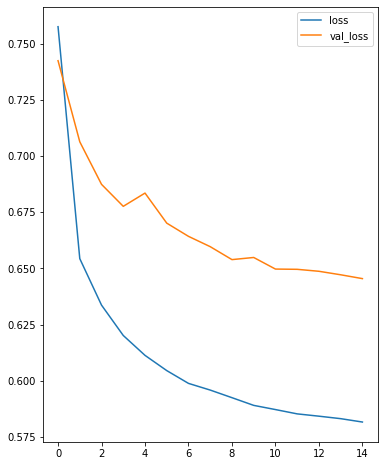

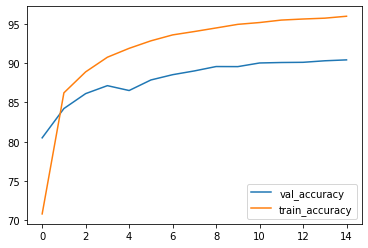

In [ ]:
plot_acc(history)

Obtenemos predicciones.

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<ipython-input-295-354ae8c4bf67>:32: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Obtenemos la matriz de confusión y el reporte de clasificación.

Aún habiendo un imbalanceo de clases considerable vemos que la red tiene un buen desempeño al predecir cualquiera de las clases. Si bien es cierto que tiene más éxito con los tweets negativos, clase predominante, pero las métricas de ajuste se asemejan mucho entre sí.

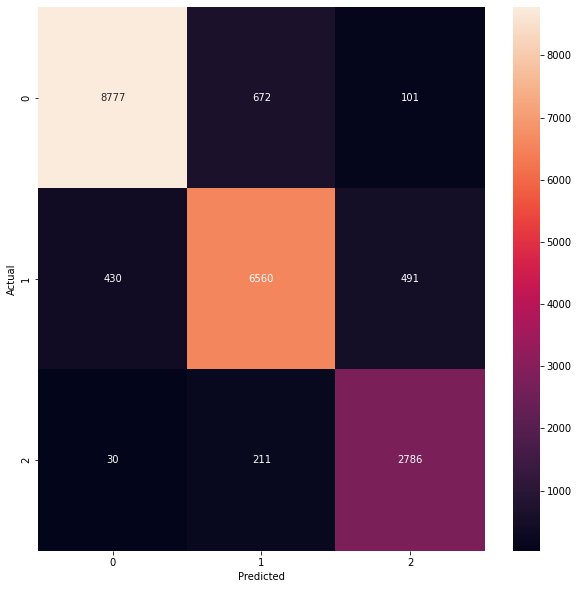

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
conf_mat = confusion_matrix(y_test, y_pred_list)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      9550
           1       0.88      0.88      0.88      7481
           2       0.82      0.92      0.87      3027

    accuracy                           0.90     20058
   macro avg       0.89      0.91      0.89     20058
weighted avg       0.91      0.90      0.90     20058



## 2. Modelo 2 LSTM *bidirectional*

Vamos a darle una vuelta de tuerca e intentaremos definir una red LSTM algo más compleja. Hemos visto que aunque el rendimiento de la red anterior fuese adecuado existia algo de sobreajuste en el modelo. Aqui aplicaremos algunas técnicas para tratar de reducir este sobreajuste y también aumentar la precisión de la red.

In [ ]:
from torch.autograd import Variable
dropout=0.1
num_layers=2

class LSTM1(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, hidden_dim,
               output_dim, dropout, num_layers):
    super().__init__()

    self.output_size = output_dim
    self.hidden_dim = hidden_dim
    self.num_layers=num_layers

    self.embedding = nn.Embedding(vocabulary_size, embedding_size)
    #self.embedding.weights = torch.nn.Parameter(embedding_matrix)
    self.lstm = nn.LSTM(embedding_size, hidden_dim,bidirectional=True, num_layers=self.num_layers,dropout=dropout, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim*2, hidden_dim)
    self.fc2=nn.Linear(hidden_dim,output_dim)
    self.dropout = nn.Dropout(dropout)
    self.sig = nn.Softmax()

  def forward(self, x):

    x = self.embedding(x)

    x = x.float()

    lstm_out, hidden = self.lstm(x)
    lstm_out = lstm_out[:, -1, :]

    out = self.dropout(lstm_out)
    out = self.fc1(out)
    out = self.dropout(out)
    out = self.fc2(out)
    sig_out = self.sig(out)
    return sig_out

In [ ]:
model2=LSTM1(max_features, embedding_dim, hidden_dim,
               output_dim, dropout,num_layers)

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)

In [ ]:
print(model2)

LSTM1(
  (embedding): Embedding(65067, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (sig): Softmax(dim=None)
)


In [ ]:
history2 = {"loss":[], "val_loss":[], "acc":[], "val_accuracy":[]}

In [ ]:
print("Begin training.")
epochs=15
if(train_on_gpu):
    model2.cuda()
for e in range(epochs):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model2.train()

    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model2(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model2.eval()
        for X_val_batch, y_val_batch in valid_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model2(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    history2['loss'].append(train_epoch_loss/len(train_loader))
    history2['val_loss'].append(val_epoch_loss/len(valid_loader))
    history2['acc'].append(train_epoch_acc/len(train_loader))
    history2['val_accuracy'].append(val_epoch_acc/len(valid_loader))
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(valid_loader):.3f}')

Begin training.


<ipython-input-307-e8ef1482b571>:35: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 000: | Train Loss: 0.74376 | Val Loss: 0.78141 | Train Acc: 72.870| Val Acc: 76.453
Epoch 001: | Train Loss: 0.66233 | Val Loss: 0.70950 | Train Acc: 85.173| Val Acc: 83.942
Epoch 002: | Train Loss: 0.64817 | Val Loss: 0.70051 | Train Acc: 87.134| Val Acc: 84.839
Epoch 003: | Train Loss: 0.63471 | Val Loss: 0.69665 | Train Acc: 88.847| Val Acc: 85.278
Epoch 004: | Train Loss: 0.62563 | Val Loss: 0.67957 | Train Acc: 90.138| Val Acc: 86.998
Epoch 005: | Train Loss: 0.62040 | Val Loss: 0.67426 | Train Acc: 90.896| Val Acc: 87.586
Epoch 006: | Train Loss: 0.61365 | Val Loss: 0.67507 | Train Acc: 91.734| Val Acc: 87.496
Epoch 007: | Train Loss: 0.61091 | Val Loss: 0.67495 | Train Acc: 92.201| Val Acc: 87.531
Epoch 008: | Train Loss: 0.60873 | Val Loss: 0.66530 | Train Acc: 92.468| Val Acc: 88.508
Epoch 009: | Train Loss: 0.60454 | Val Loss: 0.66348 | Train Acc: 92.999| Val Acc: 88.653
Epoch 010: | Train Loss: 0.60209 | Val Loss: 0.65955 | Train Acc: 93.340| Val Acc: 89.107
Epoch 011:

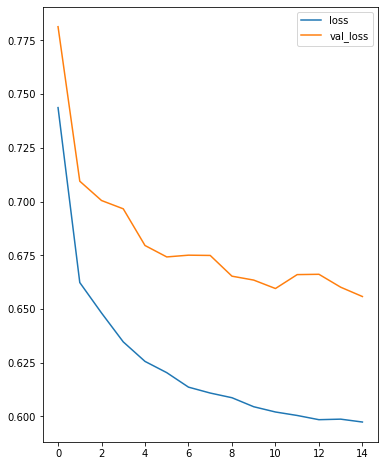

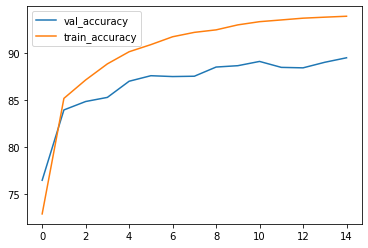

In [ ]:
plot_acc(history2)

In [ ]:
y_pred_list = []
with torch.no_grad():
    model2.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<ipython-input-307-e8ef1482b571>:35: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



In [ ]:
#y_pred_list_flat = [item for sublist in y_pred_list for item in sublist]

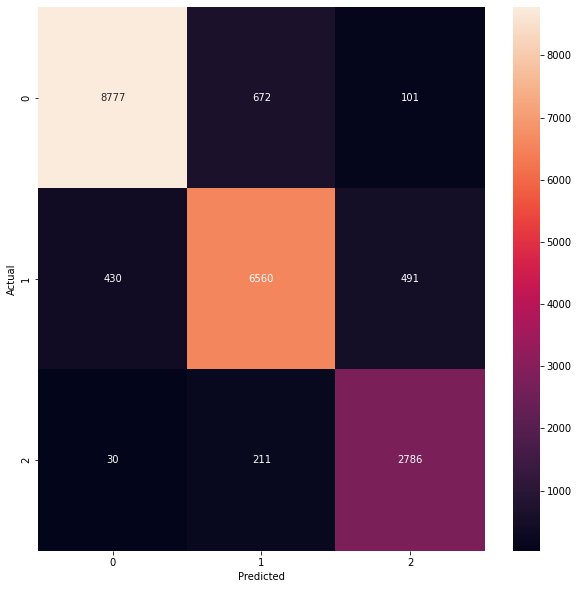

In [ ]:
conf_mat_model2 = confusion_matrix(y_test, y_pred_list)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Si bien los resultados son practicamente los mismos tenemos menos sobreajuste en el modelo. De por sí ya mostraba una precisión bastante alta y un sobreajuste reducido.

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      9550
           1       0.85      0.88      0.86      7481
           2       0.82      0.91      0.86      3027

    accuracy                           0.89     20058
   macro avg       0.87      0.89      0.88     20058
weighted avg       0.89      0.89      0.89     20058



## Modelos vistos anteriormente. Logistic Regression // MultinomialNB

Aqui tenemos que volver a trabajar con *TfidfVectorizer*, hemos tenido que reducir considerablemente la dimensionalidad dado que es un proceso que consume mucha memoria RAM. 

Ahora tenemos 200 mil observaciones que vienen representadas por unas 5746 características o palabras. Como detalle decir que se han considerado únicamente palabras que aparecen más de 50 veces en el *corpus*, se ha límitado el número de características a 20000 por si a caso y únicamente se han considerado unigramas, es decir palabras solas. 

También se ha hecho uso de *stopwords* para reducir el ruido del dataset y así excluir palabras que no aportan nada al modelo en el momento de predecir el sentimiento del tweet.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=50, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words='english',max_features=20000)
features = tfidf.fit_transform(df.text).toarray()
labels = df.Sentiment
features.shape

(200576, 5746)

Hacemos una partición 25 test y 75 entreno.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["Sentiment"], 
                                                    test_size=0.25,
                                                    random_state = 42)
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


## Logistic Regression.

Aqui vemos que el modelo no es capaz de converger y ha llegado al número máximo de iteraciones... Aún así podemos comprobar métricas de ajuste. 

Una solución a esto es mejorar el preprocesado de los datos para darle más información al modelo aunque ya vemos que vamos algo justos de memoria RAM. Todo esto por lo tanto implica un coste computacional.

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_tfidf, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precisión en el entreno: con respecto al otro dataset vemos como la regresión logística mejora significativamente e incluso con una reducción de la dimensionalidad considerable ofrece buenos resultados.

También al ver la precisión del test vemos que el modelo no sobreajusta.

In [ ]:
clf.score(count_vect.transform(X_train),y_train)

0.8613659327802595

In [ ]:
clf.score(count_vect.transform(X_test),y_test)

0.845504945756222

Vemos una curiosa tendencia del modelo a predecir como tweets negativos a los que realmente son neutrales y además no sorprende el f1-score de la clase positiva. El modelo presenta ciertos problemas cuando se ajusta con un dataset con imbalanceo de clases.

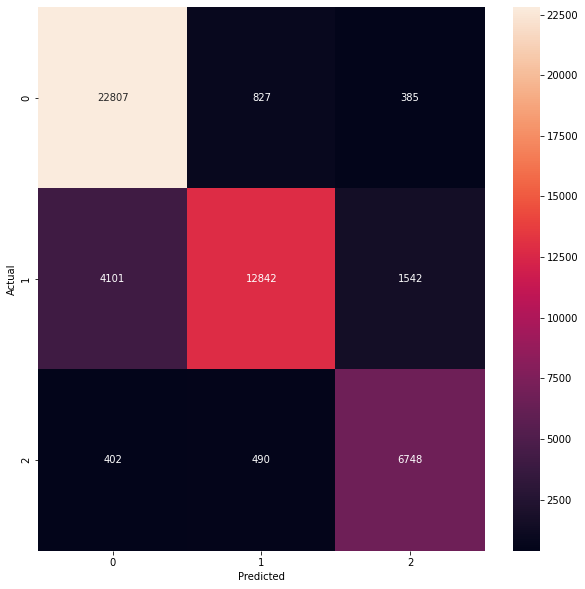

In [ ]:
y_pred = clf.predict(count_vect.transform(X_test))


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.84      0.95      0.89     24019
     neutral       0.91      0.69      0.79     18485
    positive       0.78      0.88      0.83      7640

    accuracy                           0.85     50144
   macro avg       0.84      0.84      0.83     50144
weighted avg       0.85      0.85      0.84     50144



## Multinomial Naives Bayes

Los resultados son bastante parecidos.

In [ ]:
mnb = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
mnb.score(count_vect.transform(X_train),y_train)

0.8558817272920655

In [ ]:
mnb.score(count_vect.transform(X_test),y_test)

0.8368897574984046

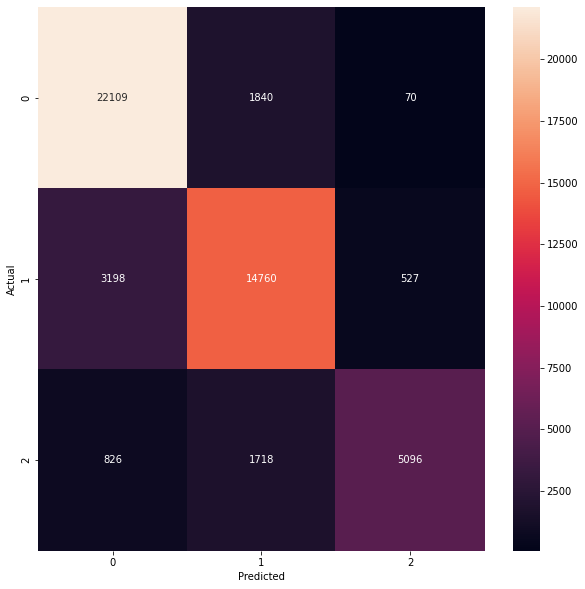

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = mnb.predict(count_vect.transform(X_test))


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.92      0.88     24019
     neutral       0.81      0.80      0.80     18485
    positive       0.90      0.67      0.76      7640

    accuracy                           0.84     50144
   macro avg       0.85      0.80      0.82     50144
weighted avg       0.84      0.84      0.83     50144



Aqui hay dos opciones que han quedado pendientes. La primera es utilizar una maquina de soporte de vectores como clasificador. Si bien se sabe es un algoritmo con un coste computacional bastante más alto que el que hemos visto, también suele ofrecer mejores resultados.

Otra parte a destacar y que queda pendiente sobretodo en el desarrollo de un producto o idea de negocio es desarrollar un modelo sobre RoBERTa aprovechando su preentreno y añadiendole un clasificador. Así aprovechariamos el concepto de *Transfer Learning* para crear una red muy potente para que realiza una tarea muy específica. Anteriormente hemos visto que se han creado unas cuantas de estas redes sobre RoBERTa para realizar distintas tareas. Si tuviesemos que elegir un modelo para trabajar sobre datos de Twitter sería ese sin duda.

Hemos visto que las redes LSTM sencillas que hemos creado ofrecen resultados bastantes buenos con respecto a los otros modelos. Aunque no es una comparación justa, al fin y al cabo las etiquetas de modelo se han asignado gracias a un modelo de *deep learning* y las técnicas que utilizan las redes LSTM son algo más avanzadas que las de últimos dos algoritmos.